In [1]:
from fastkaggle import get_dataset
from pathlib import Path
from fastai.tabular.all import *

## Dataset

My first attempt at a clustering algorithm was a botched attempt at a DBSCAN from scratch. I wanted to use a dataset that was clearly segmented visually for ease of tracking what was happening. I haven't quite worked out the kinks in the DBSCAN notebook yet, but I don't see any harm in using it for k-means as well.

The data we're going to target is the *spending score* as it relates to *annual income*

In [2]:
path = Path('data/dbscan')
dataset = 'vjchoudhary7/customer-segmentation-tutorial-in-python'

In [3]:
if not path.exists():
    data = get_dataset(path, dataset, unzip=True)

In [4]:
df = pd.read_csv(path/'Mall_Customers.csv', low_memory=False)

In [5]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Plotting the Target Datapoints

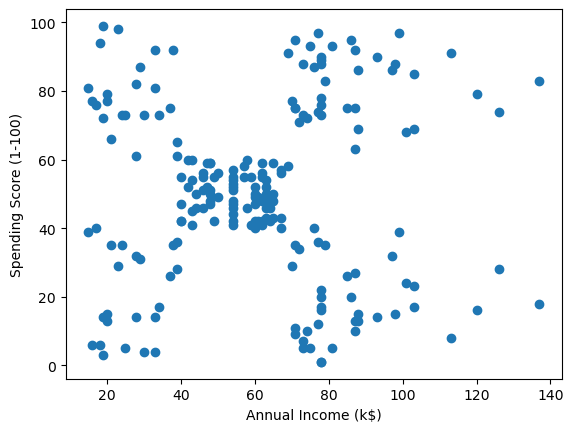

In [6]:
x = df['Annual Income (k$)']
y = df['Spending Score (1-100)']
plt.scatter(x,y)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

In [7]:
x_y_tens = torch.from_numpy(df.to_numpy()[:,3:].astype(float)).to("cuda")

## Pick *K* Number of Centroids

In [8]:
k = 5

Randomly pick `k` random points as the initial cluster centroids

In [9]:
sample_idxs = torch.randperm(x_y_tens.shape[0])[:5]
centroids = x_y_tens[sample_idxs]
centroids


tensor([[74., 10.],
        [43., 54.],
        [29., 87.],
        [78.,  1.],
        [60., 47.]], device='cuda:0', dtype=torch.float64)

In [11]:
def np_detach(tens):
    return tens.detach().cpu().numpy()

Plotting data with centroids

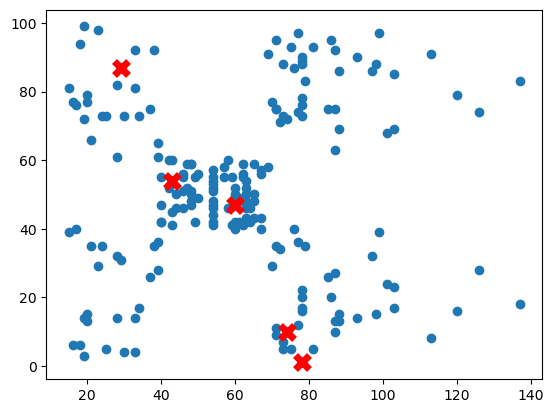

In [12]:
x = np_detach(x_y_tens)[:,0]
y = np_detach(x_y_tens)[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)
for cen in centroids:
    ax.plot(np_detach(cen)[0], np_detach(cen)[1], markersize=10, marker="x", color='r', mew=5)
    

In [13]:
(x_y_tens - centroids[0])

tensor([[-59.,  29.],
        [-59.,  71.],
        [-58.,  -4.],
        [-58.,  67.],
        [-57.,  30.],
        [-57.,  66.],
        [-56.,  -4.],
        [-56.,  84.],
        [-55.,  -7.],
        [-55.,  62.],
        [-55.,   4.],
        [-55.,  89.],
        [-54.,   5.],
        [-54.,  67.],
        [-54.,   3.],
        [-54.,  69.],
        [-53.,  25.],
        [-53.,  56.],
        [-51.,  19.],
        [-51.,  88.],
        [-50.,  25.],
        [-50.,  63.],
        [-49.,  -5.],
        [-49.,  63.],
        [-46.,   4.],
        [-46.,  72.],
        [-46.,  22.],
        [-46.,  51.],
        [-45.,  21.],
        [-45.,  77.],
        [-44.,  -6.],
        [-44.,  63.],
        [-41.,  -6.],
        [-41.,  82.],
        [-41.,   4.],
        [-41.,  71.],
        [-40.,   7.],
        [-40.,  63.],
        [-37.,  16.],
        [-37.,  65.],
        [-36.,  25.],
        [-36.,  82.],
        [-35.,  26.],
        [-35.,  51.],
        [-35.,  18.],
        [-

In [14]:
x_y_tens[0]

tensor([15., 39.], device='cuda:0', dtype=torch.float64)

In [15]:
x_y_tens.shape, centroids.shape

(torch.Size([200, 2]), torch.Size([5, 2]))

To calculate the Euclidean distance between two matrices A and B using the Frobenius norm, you first subtract one matrix from the other element-wise to obtain a matrix C, where C(i,j) = A(i,j) - B(i,j). Then, you compute the Frobenius norm of matrix C:

dist = ||C||F

This distance metric quantifies the dissimilarity between the two matrices in terms of the overall magnitude of their differences. The smaller the distance, the more similar the matrices are in terms of their element values.

It's worth noting that when working with vectors (1-dimensional matrices), the Frobenius norm reduces to the usual Euclidean norm.

In [16]:
(x_y_tens.unsqueeze(1) - centroids.unsqueeze(0)).shape

torch.Size([200, 5, 2])

In [17]:
(x_y_tens.unsqueeze(1) - centroids.unsqueeze(0))[-1]

tensor([[ 63.,  73.],
        [ 94.,  29.],
        [108.,  -4.],
        [ 59.,  82.],
        [ 77.,  36.]], device='cuda:0', dtype=torch.float64)

## Calculate the Frobenius norm

In [18]:
def euclidean_dist(a, b):
    return torch.norm(a-b, dim=-1)

Get the initial distance of each point to its nearest cluster

In [19]:
distances = euclidean_dist(x_y_tens.unsqueeze(1), centroids.unsqueeze(0))

Assign each point to its nearest cluster centroid

In [20]:
cluster_assignments = torch.argmin(distances, dim=1)

In [21]:
og_cluster_assignments = cluster_assignments.clone()

Plotting initial cluster assignments

In [22]:
def plot_clusters(data, centroids, assignments):
    plt.clf()
    data, centroids, assignments = np_detach(data), np_detach(centroids), np_detach(assignments)
    plt.scatter(data[:,0], data[:,1], c=assignments, s=30)
    plt.scatter(centroids[:,0], centroids[:,1], marker='x', color='red', s=60)

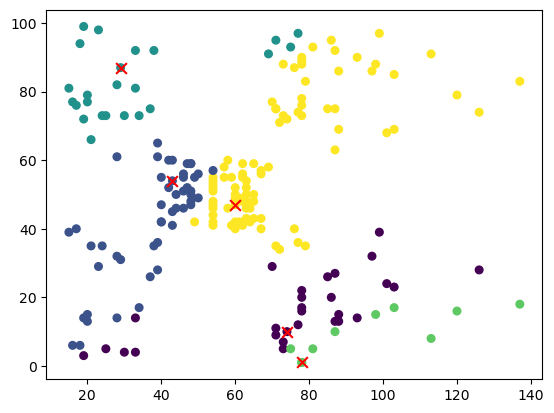

In [23]:
plot_clusters(x_y_tens, centroids, cluster_assignments)

In [24]:
def assign_to_nearest_centroid(data, centroids):
    distances = euclidean_dist(data.unsqueeze(1), centroids.unsqueeze(0))
    cluster_assignments = torch.argmin(distances, dim=1)
    return cluster_assignments

In [25]:
cluster_assignments

tensor([1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 0, 2,
        1, 2, 1, 1, 1, 2, 0, 2, 0, 2, 0, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4,
        1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 2, 0, 4, 4, 2, 0, 4, 0, 4, 4, 4, 0, 4, 0, 4, 0, 4, 3, 2, 4, 4,
        0, 2, 4, 4, 0, 4, 0, 4, 0, 4, 0, 4, 3, 4, 3, 4, 4, 4, 3, 4, 0, 4, 0, 4,
        0, 4, 0, 4, 3, 4, 0, 4, 0, 4, 0, 4, 0, 4, 3, 4, 0, 4, 0, 4, 3, 4, 0, 4,
        3, 4, 3, 4, 0, 4, 3, 4], device='cuda:0')

In [26]:
new_centroids = torch.zeros_like(centroids)
new_centroids

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0', dtype=torch.float64)

In [27]:
test_count = 0
for i in range(centroids.shape[0]):
    assigned_points = x_y_tens[cluster_assignments == i]
    test_count += assigned_points.shape[0]
test_count

200

In [28]:
centroids

tensor([[74., 10.],
        [43., 54.],
        [29., 87.],
        [78.,  1.],
        [60., 47.]], device='cuda:0', dtype=torch.float64)

Calculate the centroids of the newly formed clusters, and repeat

In [29]:
def update_centroids(data, cluster_assignments, centroids): 
    new_centroids = torch.zeros_like(centroids)
    for i in range(centroids.shape[0]):
        assigned_points = data[cluster_assignments == i]
        if len(assigned_points) > 0:
            new_centroids[i] = torch.mean(assigned_points, dim=0)
    return new_centroids

A single centroid update

In [30]:
update_centroids(x_y_tens, cluster_assignments, centroids)

tensor([[75.0357, 16.5000],
        [37.6327, 42.4898],
        [32.9583, 83.1667],
        [97.0000,  9.6000],
        [71.9775, 60.7191]], device='cuda:0', dtype=torch.float64)

Plotting our single centroid update

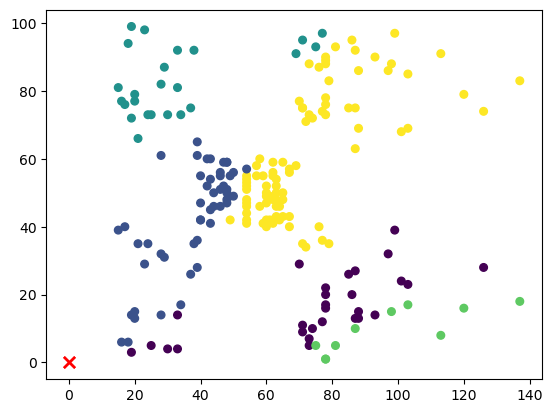

In [31]:
plot_clusters(x_y_tens, new_centroids, cluster_assignments)

## Create K-Means Loop

In [32]:
def k_means(data, centroids, iterations=10):
    for i in range(iterations):
        cluster_assignments = assign_to_nearest_centroid(data, centroids)
        new_centroids = update_centroids(data, cluster_assignments, centroids)
    cluster_assignments = assign_to_nearest_centroid(data, centroids)
    return cluster_assignments, new_centroids

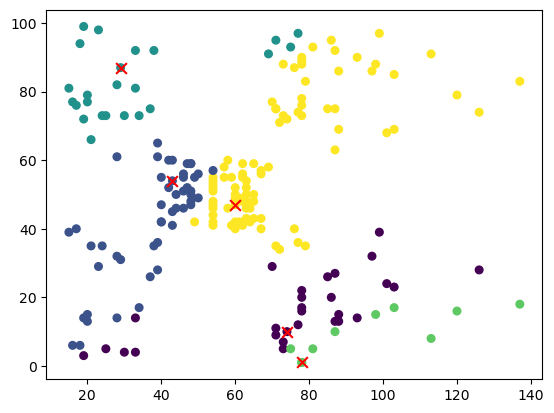

In [33]:
plot_clusters(x_y_tens, centroids, cluster_assignments)

In [34]:
cluster_assignments, centroids = k_means(x_y_tens, centroids)

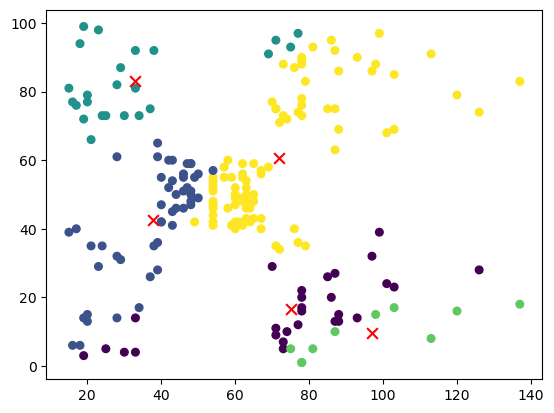

In [35]:
plot_clusters(x_y_tens, centroids, cluster_assignments)

In [36]:
centroids = og_centroids
cluster_assignments = og_cluster_assignments

In [37]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

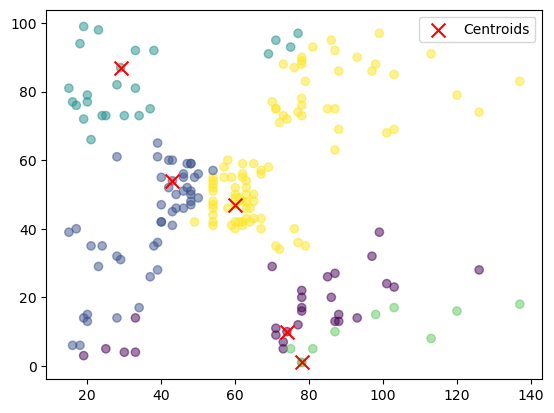

In [38]:
fig, ax = plt.subplots()

# Set up the initial plot
scatter = ax.scatter(np_detach(x_y_tens[:, 0]), np_detach(x_y_tens[:, 1]), c=np_detach(cluster_assignments), cmap='viridis', alpha=0.5)
centroid_plot = ax.scatter(np_detach(centroids[:, 0]), np_detach(centroids[:, 1]), c='red', marker='x', s=100, label='Centroids')
ax.legend()

In [39]:
def init():
    return scatter, centroid_plot

In [40]:
def update(frame):
    global x_y_tens, centroids, cluster_assignments
    
    # Step 1: Assign x_y_tens points to the nearest centroid
    cluster_assignments = assign_to_nearest_centroid(x_y_tens, centroids)

    # Step 2: Update centroids
    updated_centroids = update_centroids(x_y_tens, cluster_assignments, centroids)

    # Update plot
    scatter.set_array(np_detach(cluster_assignments))
    centroid_plot.set_offsets(np_detach(updated_centroids))
    centroids = updated_centroids
    
    return scatter, centroid_plot

In [41]:
ani = FuncAnimation(fig, update, frames=10, init_func=init, blit=True, interval=200, repeat=False)
plt.close()
HTML(ani.to_jshtml())

In [ ]:
%timeit -n 10 k_means(x_y_tens, centroids)